# IAA – Final Project
## Energy Consumption – Maia Municipality
### CRISP-DM Notebook

Authors:  Alenxandre Rodrigues, Ricardo Lopes e Ricardo Ribeiro

## Setup and Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

plt.style.use("default")

DATA_DIR = Path("Data")
RAW_FILE = DATA_DIR / "consumo15m_11_2025.csv"  

INTERIM_DIR = Path("interim")
PROCESSED_DIR = Path("processed")

INTERIM_DIR.mkdir(exist_ok=True)
PROCESSED_DIR.mkdir(exist_ok=True)


## 1. Project Understanding

In this project, we work with high-resolution energy consumption data from the municipality of Maia.

**Main project goals:**
- Understand and characterize different types of municipal consumers (CPEs), based on their energy usage profiles.
- Evaluate the potential of the data for forecasting energy consumption for the following week.
- Identify outliers and special consumption profiles (e.g. night-only, 24/7, highly variable, etc.).

**Key analytical questions:**
- What are the main patterns in daily, weekly and seasonal consumption?
- Can we group CPEs into meaningful clusters according to their consumption profiles?
- How accurate can we be in forecasting future consumption compared to a simple baseline (same time one week before)?

**Success criteria (examples):**
- Obtain interpretable clusters with reasonable quality metrics (e.g. silhouette score).
- Achieve better forecast error (MAE / RMSE / MAPE) than the baseline in a significant portion of CPEs.
- Provide clear visual and quantitative evidence of data potential and limitations.


## 2. Data Understanding

### 2.1 Load Raw Data and Basic Overview

In [5]:
df_raw = pd.read_csv(RAW_FILE)

df_raw.head()

,CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
0,PT0002000089069203YG,2022-12-31 00:15:00,NaN,0.296,NaN,NaN
1,PT0002000089069203YG,2022-12-31 00:30:00,NaN,0.292,NaN,NaN
2,PT0002000089069203YG,2022-12-31 00:45:00,NaN,0.284,NaN,NaN
3,PT0002000089069203YG,2022-12-31 01:00:00,NaN,0.280,NaN,NaN
4,PT0002000089069203YG,2022-12-31 01:15:00,NaN,0.272,NaN,NaN


In [6]:
df_consumo = pd.read_excel("Data\Consumo x tempo.xlsx")
df_consumo

,Unnamed: 0,Unnamed: 1,Mês de Datetime,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,NomeInstalação,Nome Inst,janeiro de 2019,fevereiro de 2019,março de 2019,abril de 2019,maio de 2019,junho de 2019,julho de 2019,agosto de 2019,...,outubro de 2022,novembro de 2022,dezembro de 2022,janeiro de 2023,fevereiro de 2023,março de 2023,abril de 2023,maio de 2023,junho de 2023,julho de 2023
1,Aeródromo De Vilar De Luz,Aeródromo de Vilar de Luz,16518,14860.25,13015.5,14620,12672.25,11411,11901,10542.25,...,13816.25,17865,17528.5,21769,17538,17622.25,13349.75,12726.75,12742.25,12981
2,Auditório Venepor,Auditório Venepor,416.5,78.75,280,477,114.75,314.5,96.5,68.5,...,207.75,187.5,121.25,85.75,88.25,88.75,74.25,73.75,149.25,25.75
3,Campo Municipal De Jogos De Milheirós,Campo Municipal de Jogos de Milheirós,3248,2631.75,3687.25,1641.25,1757.25,2482.75,1278,3881.5,...,2414,2683.75,2367,2301.75,1918,2034.75,1785,1354.25,1290.5,1770.5
4,Casa Do Alto,Casa do Alto,6132,5035.5,4856.5,4843.75,3847.5,3019.25,3514,2146.5,...,3117.75,3388.5,3045.75,3504.25,2928,3206.25,2401.5,2883.25,3081.75,3236.75
5,Centro Escolar Da Gandra,Centro Escolar da Gandra,9303.75,8509.75,8393.5,7483.5,8109.25,7913.75,6579.25,962.5,...,6647.25,6759.25,6390.25,7595.25,6385,7525,4970,6245.25,5982.5,5125
6,Centro Escolar Da Pícua,Centro Escolar da Pícua,10715.5,9086.75,6816,4672.5,4399.5,3112.75,2068.75,804.5,...,3192,3725,4658.5,6712.25,5309.75,5820.75,2909,3630.25,4165.25,2573.75
7,Centro Escolar De Folgosa,Centro Escolar de Folgosa,3525.75,3111.25,2972.75,2565.5,3146.5,2470.75,1543.25,1455,...,4215.5,4554.75,3974.5,5002,4158.75,4746.75,3297.5,4316.75,3995,2675.75
8,Centro Escolar De Mandim,Centro Escolar de Mandim,4919,4193,3987,3665.25,4646.75,3873.25,3806,2554,...,6351,5109,5119.75,6382.25,5451,5719.75,3823,4653.25,4424.5,4029.5
9,Centro Escolar De Moutidos,Centro Escolar de Moutidos,7049.5,5339.25,5592,4550.75,4388.25,2857.5,2186.25,843.75,...,4064.5,3933.5,3277.25,3830.75,3333.25,4032,3218.5,4234.75,4286.75,3098.25


In [7]:
df_consumo = pd.read_excel("Data\Total (Jan. 2019 - Jul. 2023).xlsx")
df_consumo

,NomeInstalação,Unnamed: 1
0,Torre Do Lidador (E/Ou Paços Do Concelho?),8778385.75
1,Fórum Da Maia,1424770.00
2,Complexo Municipal Das Piscinas Águas Santas,1216945.25
3,Estádio Municipal Prof. Dr. José Vieira De Car...,1198340.75
4,Parque Central Da Maia,992752.00
5,Complexo Municipal Das Piscinas De Gueifães,948115.75
6,Complexo Municipal Das Piscinas De Folgosa,935583.25
7,Aeródromo De Vilar De Luz,818876.50
8,Complexo Municipal De Ténis,800163.00
9,Complexo Municipal Ginástica,738802.50


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940182 entries, 0 to 5940181
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   CPE             object 
 1   tstamp          object 
 2   DadosdeConsumo  float64
 3   PotActiva       float64
 4   PotReactIndut   float64
 5   PotReactCapac   float64
dtypes: float64(4), object(2)
memory usage: 271.9+ MB


In [9]:
df_raw.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CPE,5940182,91,PT0002000068856906VS,81776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tstamp,5940182,81777,2024-10-01 00:00:00,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DadosdeConsumo,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PotActiva,5940182.0,NaN,NaN,NaN,8.093966,23.018327,0.0,0.12,2.0,7.0,574.0
PotReactIndut,3668710.0,NaN,NaN,NaN,1.715323,3.38557,0.0,0.0,0.0,2.0,177.0
PotReactCapac,3668710.0,NaN,NaN,NaN,0.65256,1.662369,0.0,0.0,0.0,1.0,124.0


### 2.2 Basic Cleaning for Exploration

In [10]:
df = df_raw.copy()

time_col = "tstamp"       
power_col = "PotActiva"
react_ind_col = "PotReactIndut"
react_cap_col = "PotReactCapac"
consumption_col = "DadosdeConsumo"

df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])
df = df.sort_values(["CPE", time_col])

for col in [power_col, react_ind_col, react_cap_col, consumption_col]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print('Shape after basic cleaning:', df.shape)
df.head()

Shape after basic cleaning: (5940182, 6)


,CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
2412027,PT0002000032936306KX,2024-03-01 00:15:00,NaN,0.0,NaN,NaN
2412028,PT0002000032936306KX,2024-03-01 00:30:00,NaN,0.0,NaN,NaN
2412029,PT0002000032936306KX,2024-03-01 00:45:00,NaN,0.0,NaN,NaN
2412030,PT0002000032936306KX,2024-03-01 01:00:00,NaN,0.0,NaN,NaN
2412031,PT0002000032936306KX,2024-03-01 01:15:00,NaN,0.0,NaN,NaN


In [11]:
# Missing value percentage per column
df.isna().mean().sort_values(ascending=False)

DadosdeConsumo    1.000000
PotReactIndut     0.382391
PotReactCapac     0.382391
CPE               0.000000
tstamp            0.000000
PotActiva         0.000000
dtype: float64

### 2.3 Descriptive Statistics of Numerical Variables

In [12]:
num_cols = [power_col, react_ind_col, react_cap_col, consumption_col]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
PotActiva,5940182.0,8.093966,23.018327,0.0,0.12,2.0,7.0,574.0
PotReactIndut,3668710.0,1.715323,3.385570,0.0,0.00,0.0,2.0,177.0
PotReactCapac,3668710.0,0.652560,1.662369,0.0,0.00,0.0,1.0,124.0
DadosdeConsumo,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.4 Distributions – Histograms

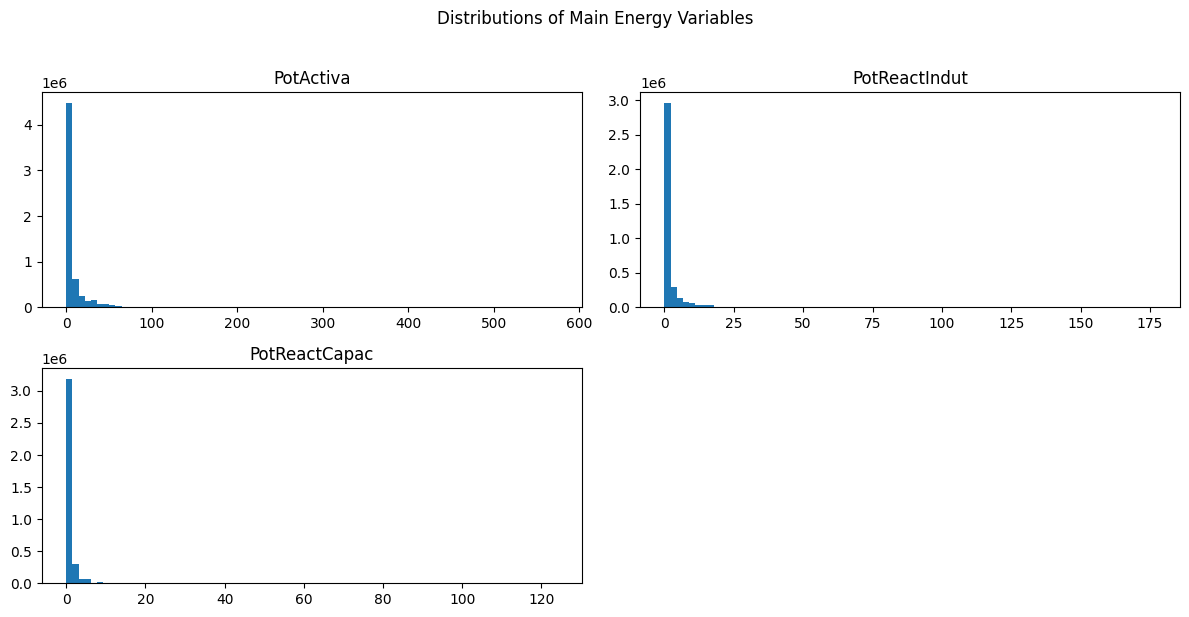

In [13]:
df[[power_col, react_ind_col, react_cap_col]].hist(
    figsize=(12, 6), bins=80, grid=False
)
plt.suptitle("Distributions of Main Energy Variables", y=1.02)
plt.tight_layout()
plt.show()

### 2.5 Outliers – Boxplots

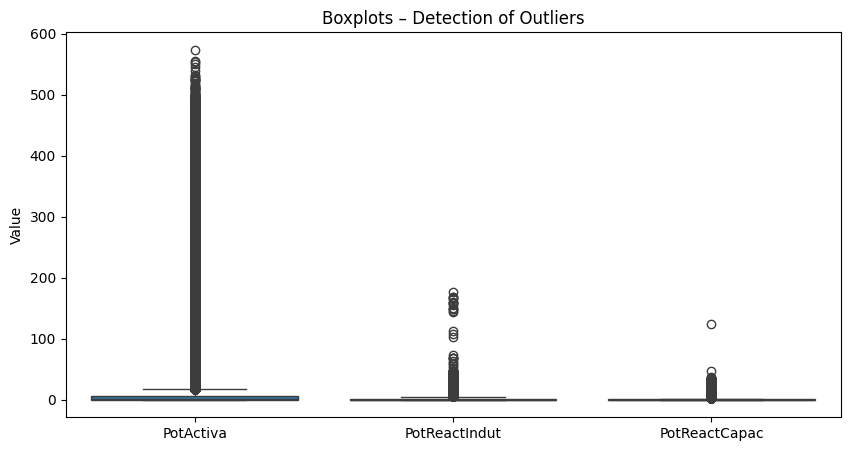

In [14]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[[power_col, react_ind_col, react_cap_col]])
plt.title("Boxplots – Detection of Outliers")
plt.ylabel("Value")
plt.show()

### 2.6 Correlations Between Variables

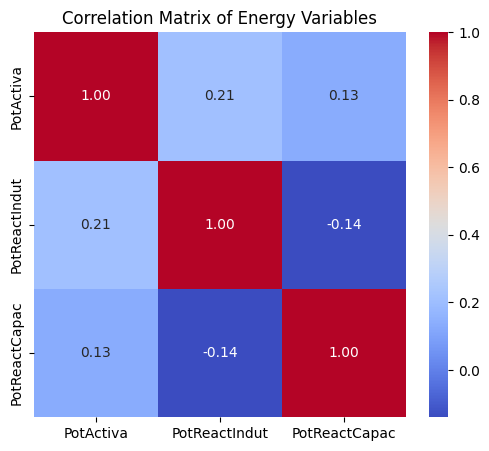

In [15]:
corr = df[[power_col, react_ind_col, react_cap_col]].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Energy Variables")
plt.show()

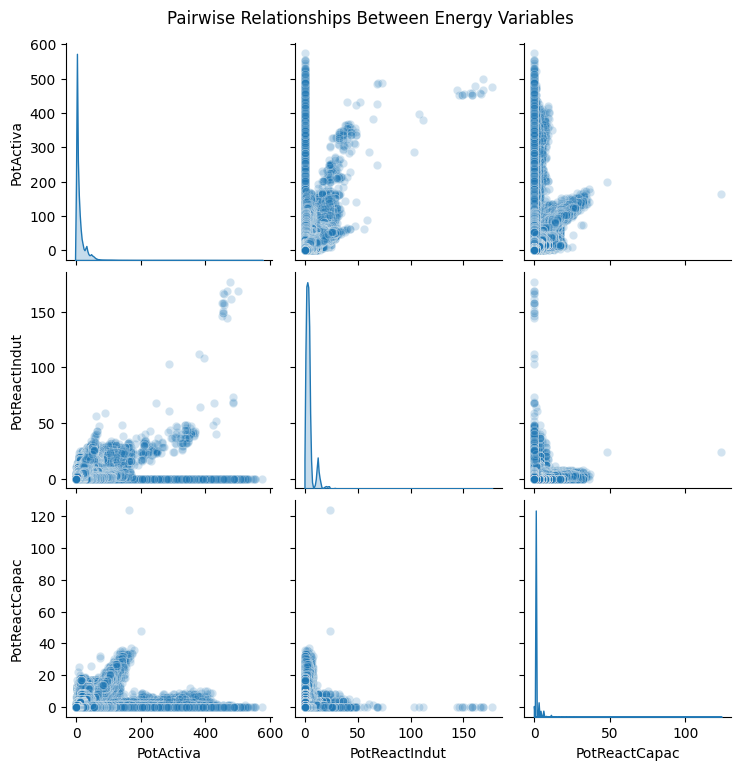

In [16]:
sns.pairplot(df[[power_col, react_ind_col, react_cap_col]].dropna(),
             diag_kind="kde", plot_kws={"alpha": 0.2})
plt.suptitle("Pairwise Relationships Between Energy Variables", y=1.02)
plt.show()

### 2.7 Temporal Coverage and Global Time Series

In [17]:
df[time_col].agg(['min', 'max'])

min   2022-12-31 00:15:00
max   2025-05-01 00:00:00
Name: tstamp, dtype: datetime64[ns]

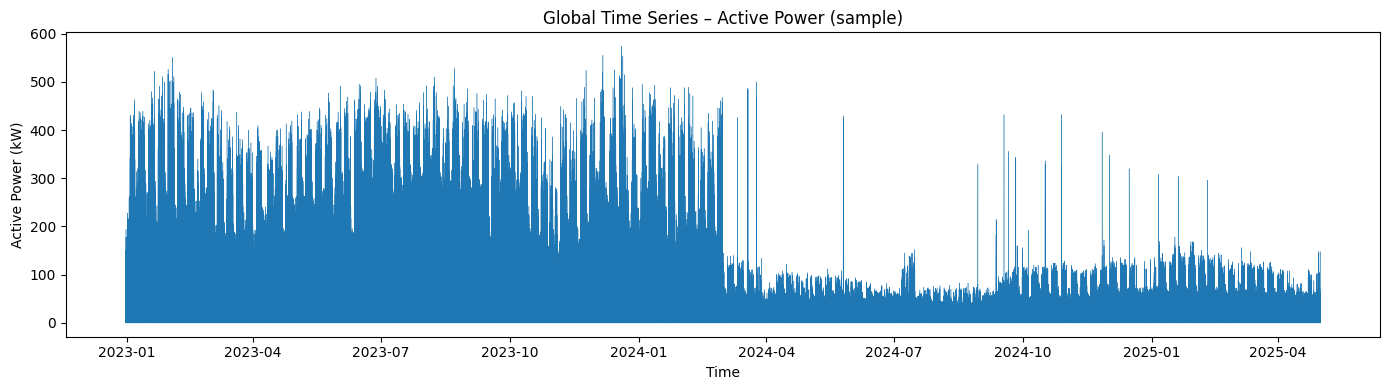

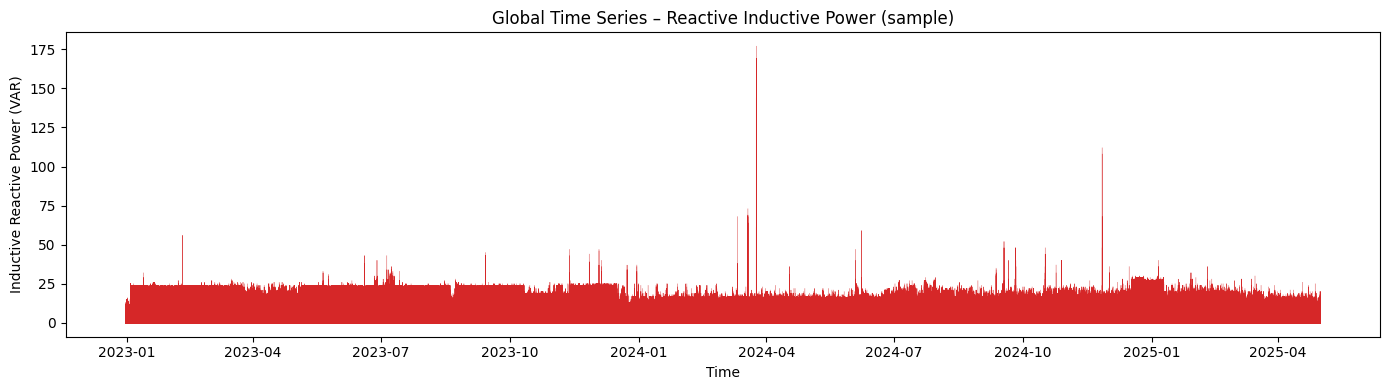

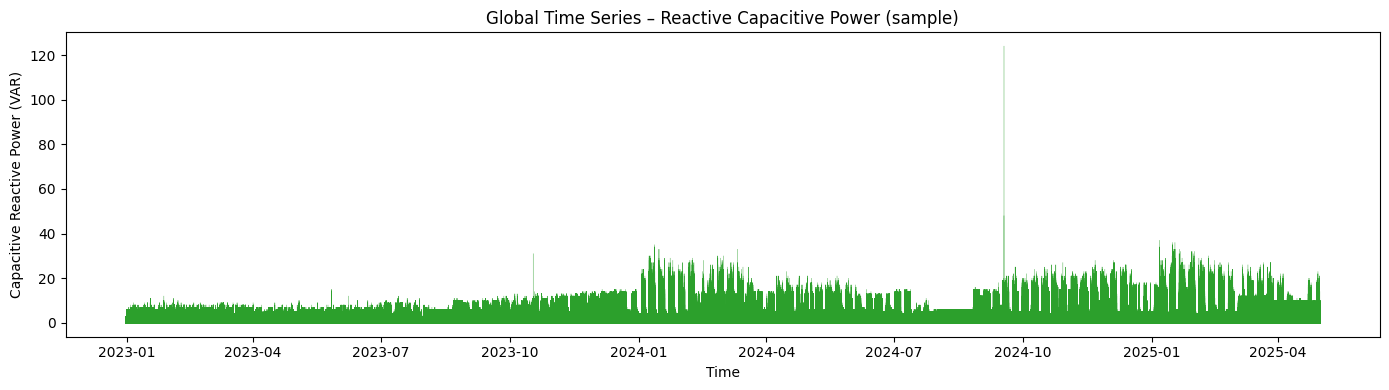

In [18]:
df_global = df.sort_values(time_col)

plt.figure(figsize=(14, 4))
plt.plot(df_global[time_col], df_global[power_col], linewidth=0.3)
plt.title("Global Time Series – Active Power (sample)")
plt.xlabel("Time")
plt.ylabel("Active Power (kW)")
plt.tight_layout()
plt.show()

df_global = df.sort_values(time_col)

plt.figure(figsize=(14, 4))
plt.plot(df_global[time_col], df_global[react_ind_col], linewidth=0.3, color="tab:red")
plt.title("Global Time Series – Reactive Inductive Power (sample)")
plt.xlabel("Time")
plt.ylabel("Inductive Reactive Power (VAR)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(df_global[time_col], df_global[react_cap_col], linewidth=0.3, color="tab:green")
plt.title("Global Time Series – Reactive Capacitive Power (sample)")
plt.xlabel("Time")
plt.ylabel("Capacitive Reactive Power (VAR)")
plt.tight_layout()
plt.show()


### 2.8 Global Daily / Weekly / Monthly Profiles

In [19]:
df["hour"] = df[time_col].dt.hour
df["weekday"] = df[time_col].dt.weekday
df["month"] = df[time_col].dt.month
df["year"] = df[time_col].dt.year
df["date"] = df[time_col].dt.date

#### 2.8.1 Average Daily Profile (All CPE Combined)

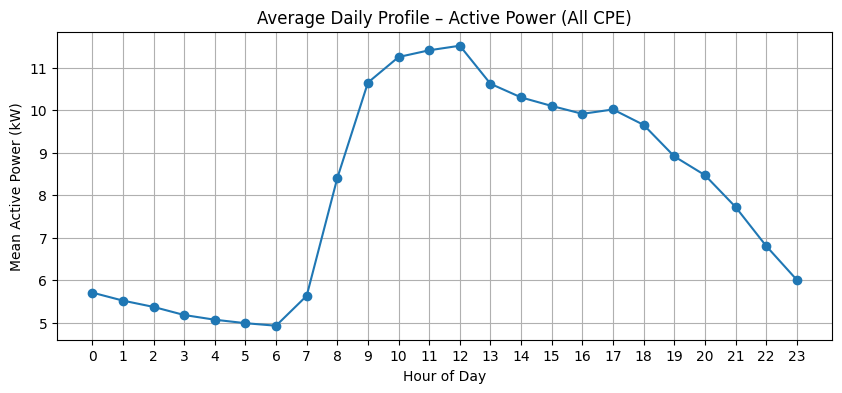

In [20]:
curve_day = df.groupby("hour")[power_col].mean()

plt.figure(figsize=(10, 4))
plt.plot(curve_day.index, curve_day.values, marker="o")
plt.title("Average Daily Profile – Active Power (All CPE)")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Active Power (kW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

#### 2.8.2 Average Weekly Profile (All CPE Combined)

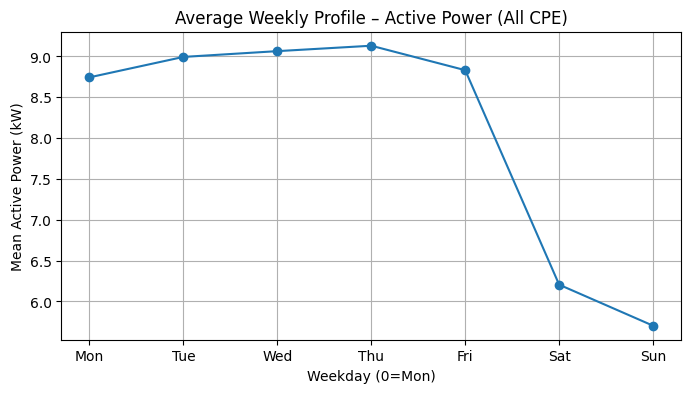

In [21]:
curve_week = df.groupby("weekday")[power_col].mean()

plt.figure(figsize=(8, 4))
plt.plot(curve_week.index, curve_week.values, marker="o")
plt.title("Average Weekly Profile – Active Power (All CPE)")
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("Mean Active Power (kW)")
plt.grid(True)
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.show()

#### 2.8.3 Average Monthly Profile

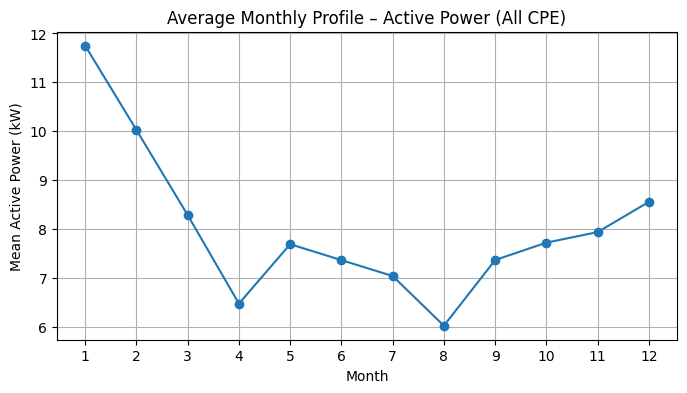

In [22]:
curve_month = df.groupby("month")[power_col].mean()

plt.figure(figsize=(8, 4))
plt.plot(curve_month.index, curve_month.values, marker="o")
plt.title("Average Monthly Profile – Active Power (All CPE)")
plt.xlabel("Month")
plt.ylabel("Mean Active Power (kW)")
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

### 2.9 Heatmaps – Hour vs Day and Year vs Month

#### 2.9.1 Hour × Day Heatmap (Average Active Power)

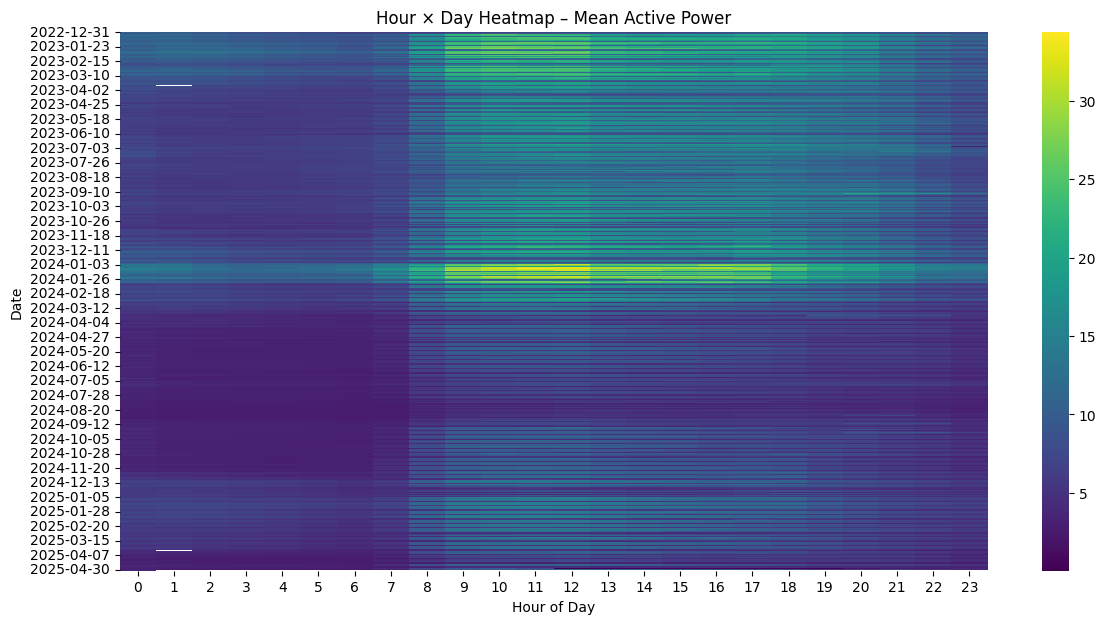

In [23]:
pivot_hour_day = df.pivot_table(
    values=power_col,
    index="date",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_hour_day, cmap="viridis")
plt.title("Hour × Day Heatmap – Mean Active Power")
plt.xlabel("Hour of Day")
plt.ylabel("Date")
plt.show()

#### 2.9.2 Year × Month Heatmap

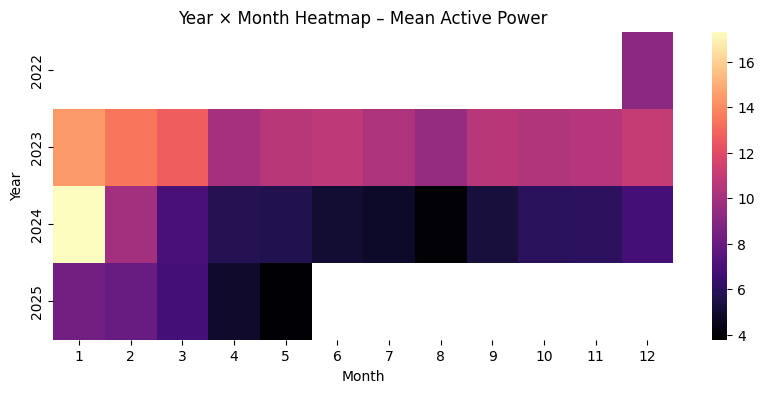

In [24]:
pivot_year_month = df.pivot_table(
    values=power_col,
    index="year",
    columns="month",
    aggfunc="mean"
)

plt.figure(figsize=(10, 4))
sns.heatmap(pivot_year_month, cmap="magma")
plt.title("Year × Month Heatmap – Mean Active Power")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

### 2.10 Per-CPE Exploration

In [25]:
n_cpe = df["CPE"].nunique()
print("Number of CPE:", n_cpe)
df["CPE"].value_counts().head()

Number of CPE: 91


CPE
PT0002000068856906VS    81776
PT0002000068856781NM    81776
PT0002000081997398TD    81774
PT0002000073231742VK    81773
PT0002000078233981HJ    81772
Name: count, dtype: int64

Example CPE: PT0002000068856906VS


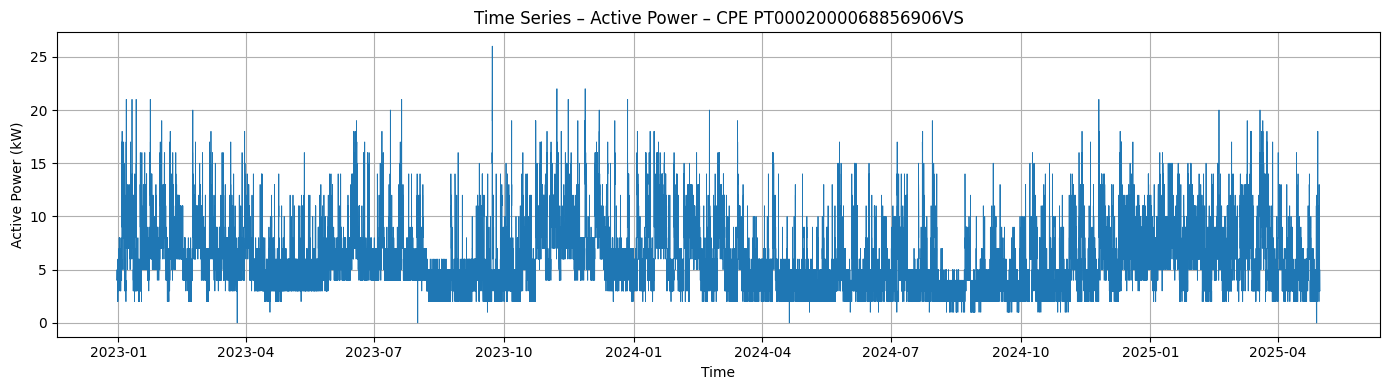

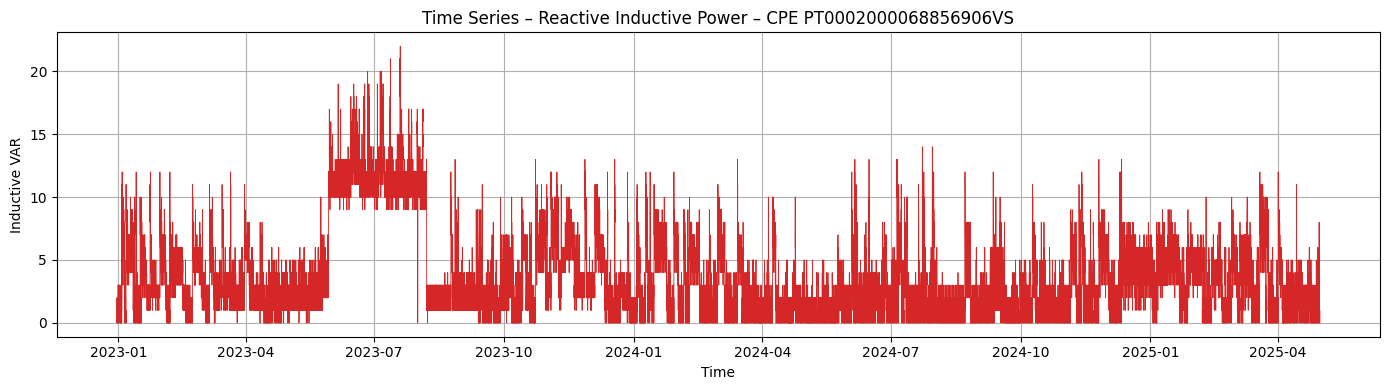

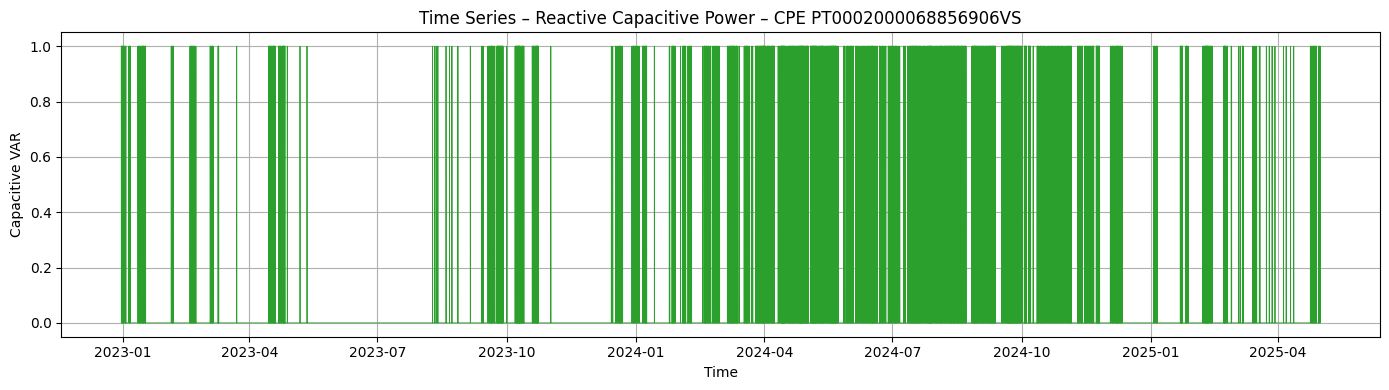

In [26]:
example_cpe = df["CPE"].value_counts().index[0]
print("Example CPE:", example_cpe)

df_cpe = df[df["CPE"] == example_cpe].sort_values(time_col)

# --- Plot Active Power ---
plt.figure(figsize=(14, 4))
plt.plot(df_cpe[time_col], df_cpe[power_col], linewidth=0.6, color='tab:blue')
plt.title(f"Time Series – Active Power – CPE {example_cpe}")
plt.xlabel("Time")
plt.ylabel("Active Power (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Reactive Inductive Power ---
plt.figure(figsize=(14, 4))
plt.plot(df_cpe[time_col], df_cpe[react_ind_col], linewidth=0.6, color='tab:red')
plt.title(f"Time Series – Reactive Inductive Power – CPE {example_cpe}")
plt.xlabel("Time")
plt.ylabel("Inductive VAR")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Reactive Capacitive Power ---
plt.figure(figsize=(14, 4))
plt.plot(df_cpe[time_col], df_cpe[react_cap_col], linewidth=0.6, color='tab:green')
plt.title(f"Time Series – Reactive Capacitive Power – CPE {example_cpe}")
plt.xlabel("Time")
plt.ylabel("Capacitive VAR")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 2.10.1 Average Daily Profile for a Single CPE

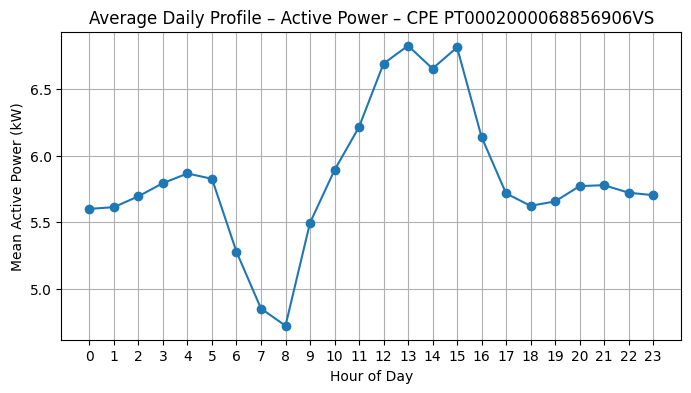

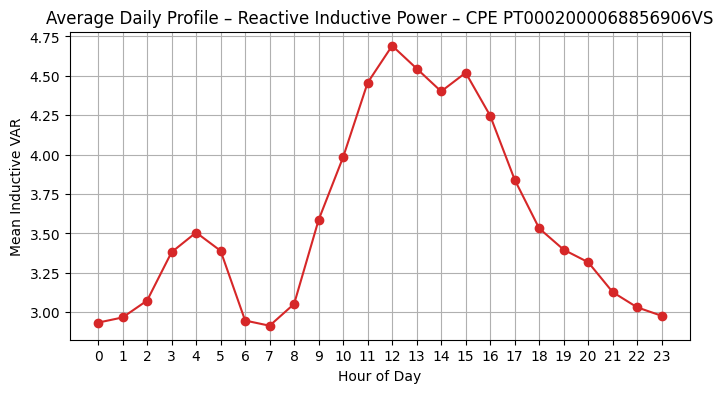

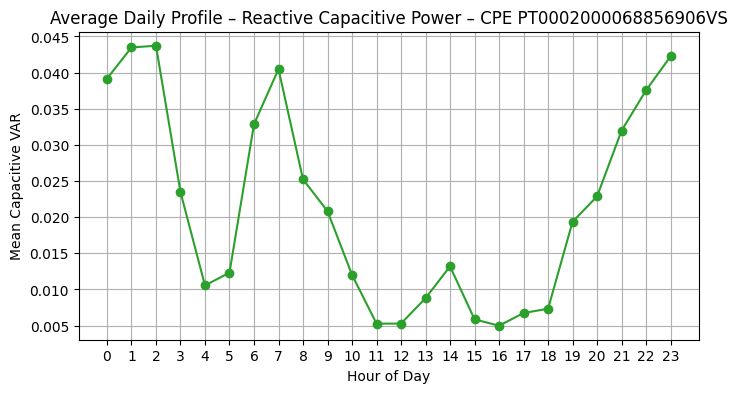

In [27]:
curve_cpe_day_act = df_cpe.groupby("hour")[power_col].mean()

plt.figure(figsize=(8, 4))
plt.plot(curve_cpe_day_act.index, curve_cpe_day_act.values, marker="o", color="tab:blue")
plt.title(f"Average Daily Profile – Active Power – CPE {example_cpe}")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Active Power (kW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


# --- Reactive Inductive Power ---
curve_cpe_day_ind = df_cpe.groupby("hour")[react_ind_col].mean()

plt.figure(figsize=(8, 4))
plt.plot(curve_cpe_day_ind.index, curve_cpe_day_ind.values, marker="o", color="tab:red")
plt.title(f"Average Daily Profile – Reactive Inductive Power – CPE {example_cpe}")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Inductive VAR")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


# --- Reactive Capacitive Power ---
curve_cpe_day_cap = df_cpe.groupby("hour")[react_cap_col].mean()

plt.figure(figsize=(8, 4))
plt.plot(curve_cpe_day_cap.index, curve_cpe_day_cap.values, marker="o", color="tab:green")
plt.title(f"Average Daily Profile – Reactive Capacitive Power – CPE {example_cpe}")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Capacitive VAR")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

Top 10 CPE por Potência Ativa total:
Index(['PT0002000078441876HB', 'PT0002000100113293JT', 'PT0002000068856781NM',
       'PT0002000068859325FL', 'PT0002000068859597LS', 'PT0002000081997398TD',
       'PT0002000114685657JR', 'PT0002000068859393XH', 'PT0002000077394934QY',
       'PT0002000068859382XF', 'PT0002000115673389QK', 'PT0002000068859187RL',
       'PT0002000068857897ZV', 'PT0002000115673471CB', 'PT0002000082549706RH',
       'PT0002000071896778MT', 'PT0002000115700602GW', 'PT0002000112989585PH',
       'PT0002000033186037TF', 'PT0002000033074862LZ'],
      dtype='object', name='CPE')


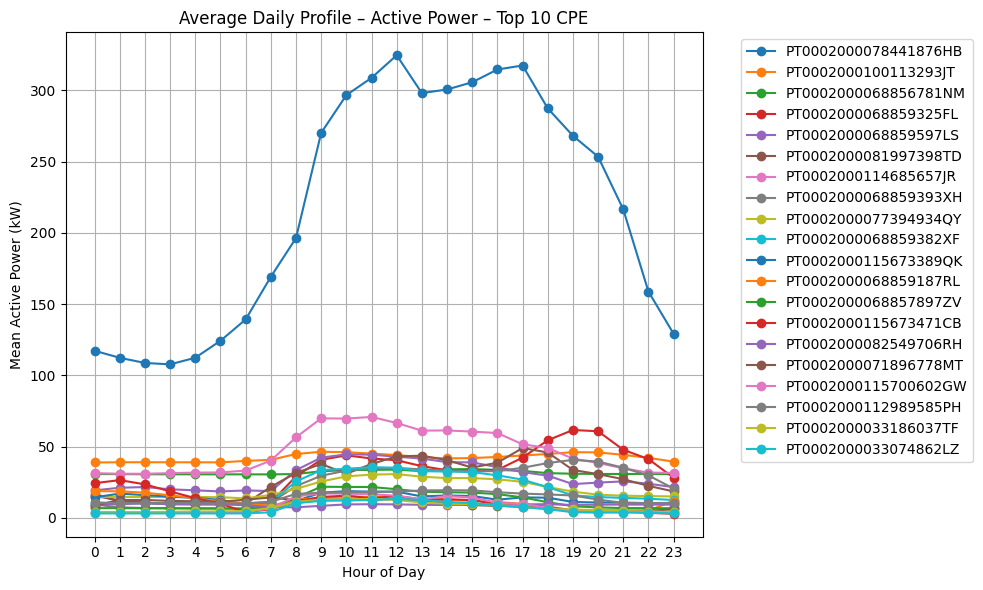

In [28]:
# 1) Top 10 CPE com maior Potência Ativa total
top10_cpe = (
    df.groupby("CPE")[power_col]          # power_col = "PotActiva"
      .sum()
      .sort_values(ascending=False)
        .head(20)

      .index
)

print("Top 10 CPE por Potência Ativa total:")
print(top10_cpe)

# 2) Filtrar apenas essas CPE
df_top10 = df[df["CPE"].isin(top10_cpe)].copy()

# Garantir que temos a coluna 'hour' (já a tinhas criado antes, mas fica aqui por segurança)
df_top10["hour"] = df_top10[time_col].dt.hour

# 3) Curvas médias diárias por CPE (Active Power)
curve_top10 = (
    df_top10
    .groupby(["CPE", "hour"])[power_col]
    .mean()
    .reset_index()
)

# 4) Plot conjunto no estilo que já usaste
plt.figure(figsize=(10, 6))
for cpe in top10_cpe:
    g = curve_top10[curve_top10["CPE"] == cpe]
    plt.plot(g["hour"], g[power_col], marker="o", label=cpe)

plt.title("Average Daily Profile – Active Power – Top 10 CPE")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Active Power (kW)")
plt.grid(True)
plt.xticks(range(0, 24))
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


#### 2.10.2 Hour × Day Heatmap for a Single CPE

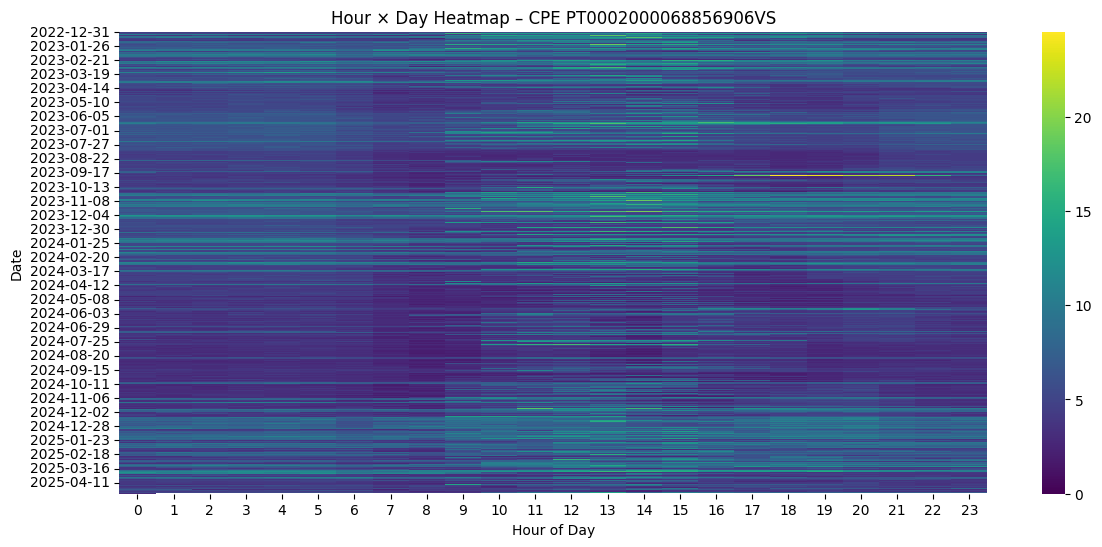

In [29]:
df_cpe["date"] = df_cpe[time_col].dt.date
df_cpe["hour"] = df_cpe[time_col].dt.hour

pivot_cpe = df_cpe.pivot_table(
    values=power_col,
    index="date",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_cpe, cmap="viridis")
plt.title(f"Hour × Day Heatmap – CPE {example_cpe}")
plt.xlabel("Hour of Day")
plt.ylabel("Date")
plt.show()

### 2.11 Detecting Anomalous CPEs via Daily Profile Distance

In [30]:
daily_curves = {}
for cpe, group in df.groupby("CPE"):
    curve = group.groupby("hour")[power_col].mean()
    curve = curve.reindex(range(24), fill_value=0.0)
    daily_curves[cpe] = curve.values

df_curves = pd.DataFrame(daily_curves).T
df_curves.columns = [f"h{h}" for h in range(24)]
df_curves.head()

,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
PT0002000032936306KX,5.166484,5.179324,5.185278,5.187030,5.181116,5.166596,4.263222,1.493275,0.127283,0.000000,...,0.004202,0.001116,0.015197,0.211475,0.973669,2.037475,3.078859,4.844419,5.191619,5.189586
PT0002000032942455NH,0.094620,0.078093,0.068734,0.064979,0.062578,0.063557,0.068662,0.083452,0.089994,0.068910,...,0.098982,0.095698,0.095222,0.102243,0.084997,0.087153,0.088551,0.148171,0.155766,0.127497
PT0002000032959511HP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PT0002000032966446CC,0.098558,0.093225,0.089989,0.088279,0.083329,0.080858,0.082148,0.079121,0.078896,0.084129,...,0.095619,0.107005,0.110312,0.111101,0.128732,0.124603,0.117414,0.123096,0.141063,0.119570
PT0002000032968749YT,2.126936,2.189174,2.165708,2.204695,2.263881,2.277563,2.235965,2.611477,6.941881,7.368053,...,4.329501,3.820859,3.499932,3.367710,2.792444,1.818141,1.578110,1.608095,1.609618,2.066631


In [31]:
X_curves = StandardScaler().fit_transform(df_curves)

dist_matrix = pairwise_distances(X_curves, metric="euclidean")
dist_mean = dist_matrix.mean(axis=1)

ranking = pd.Series(dist_mean, index=df_curves.index).sort_values(ascending=False)

print("Most different CPE:", ranking.index[0])
print("\nTop 10 most different CPEs:")
ranking.head(10)

Most different CPE: PT0002000078441876HB

Top 10 most different CPEs:


PT0002000078441876HB    42.017676
PT0002000100113293JT     9.327149
PT0002000114685657JR     8.978532
PT0002000068856781NM     7.066641
PT0002000068859325FL     6.131471
PT0002000068859597LS     5.609508
PT0002000081997398TD     5.026028
PT0002000068859393XH     4.656596
PT0002000077394934QY     4.036299
PT0002000115673471CB     4.002384
dtype: float64

#### 2.11.1 Plot Daily Curves of the Most Anomalous CPEs

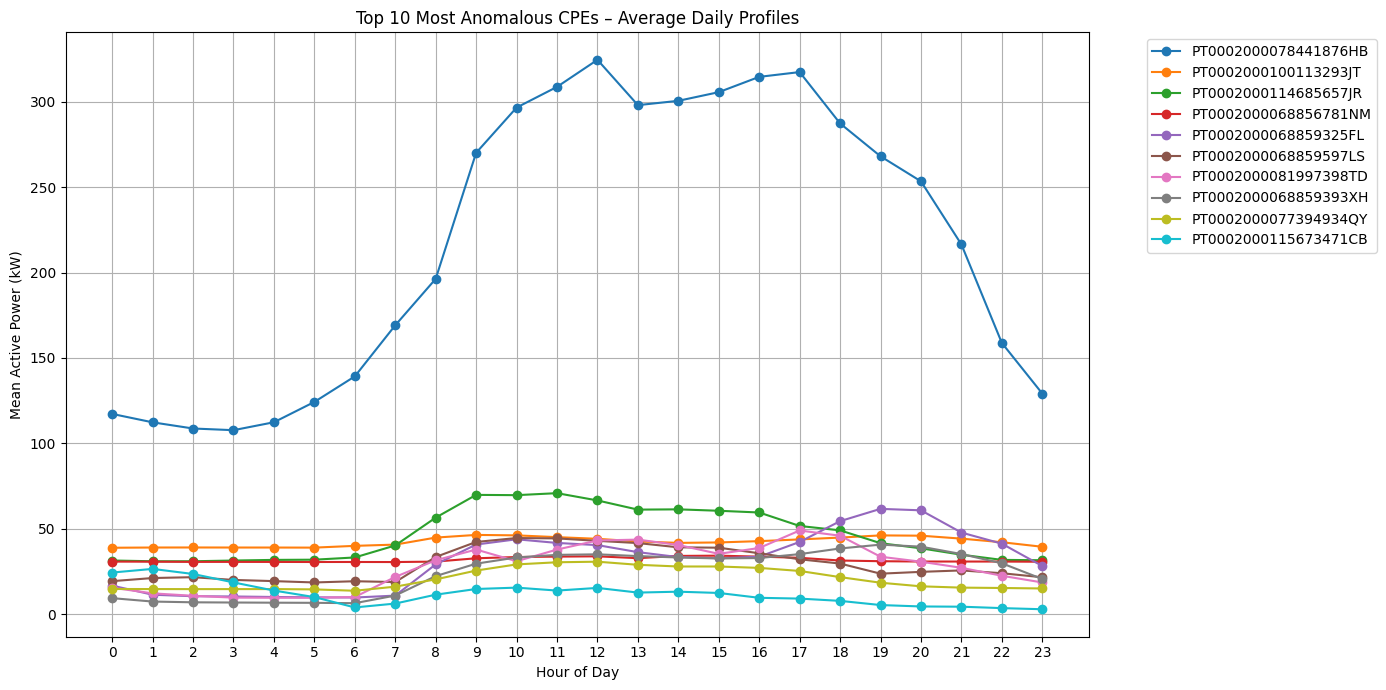

In [32]:
top10_cpes = ranking.head(10).index

plt.figure(figsize=(14, 7))
for cpe in top10_cpes:
    plt.plot(range(24), df_curves.loc[cpe].values, marker="o", label=cpe)

plt.title("Top 10 Most Anomalous CPEs – Average Daily Profiles")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Active Power (kW)")
plt.grid(True)
plt.xticks(range(24))
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

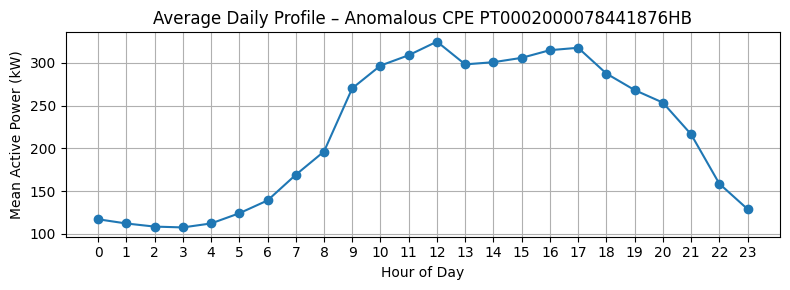

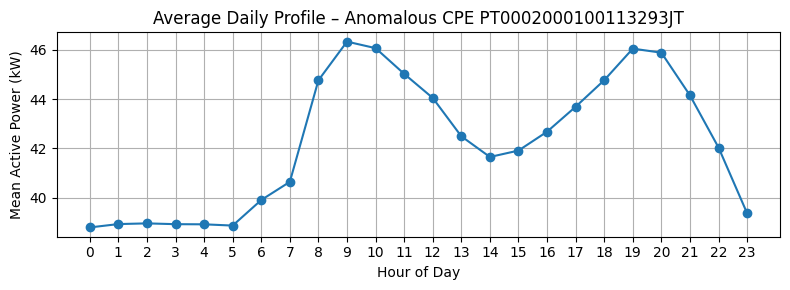

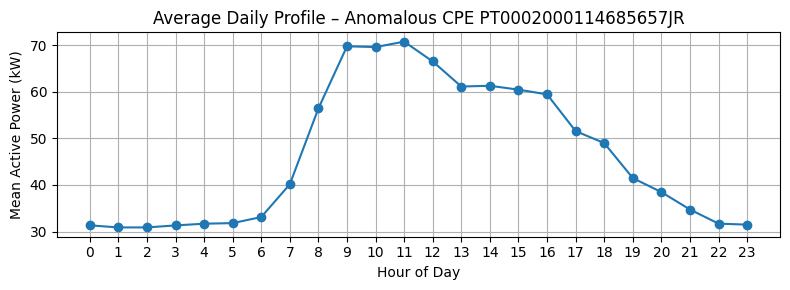

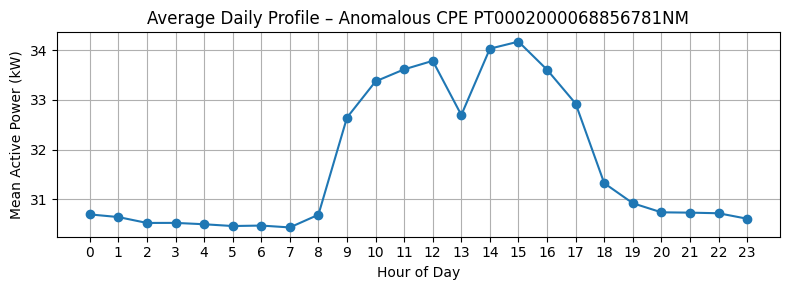

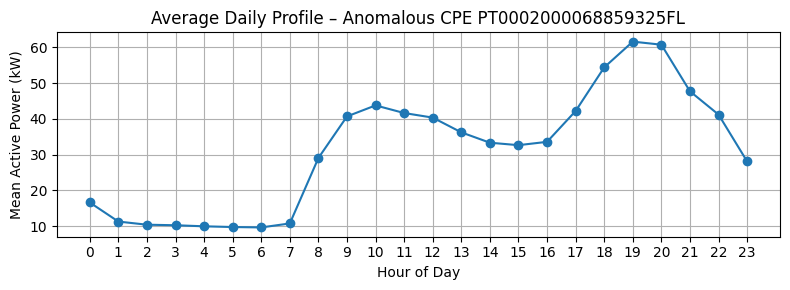

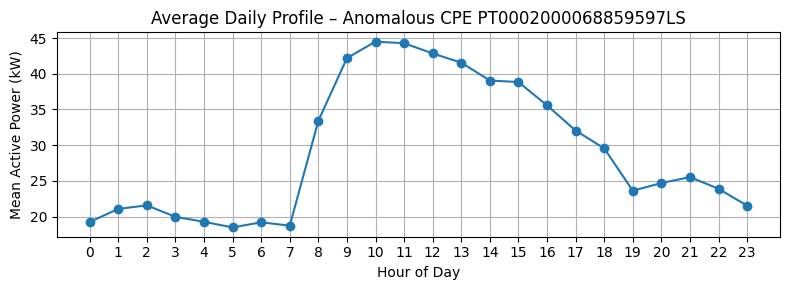

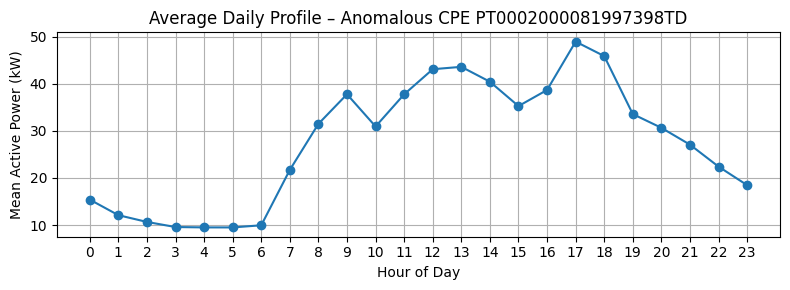

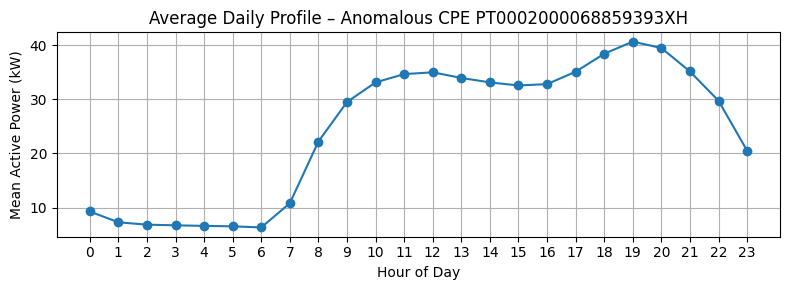

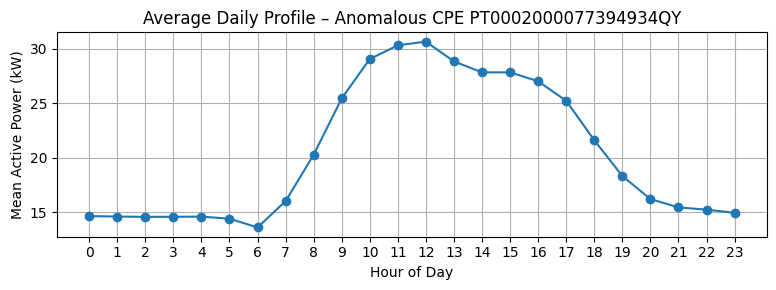

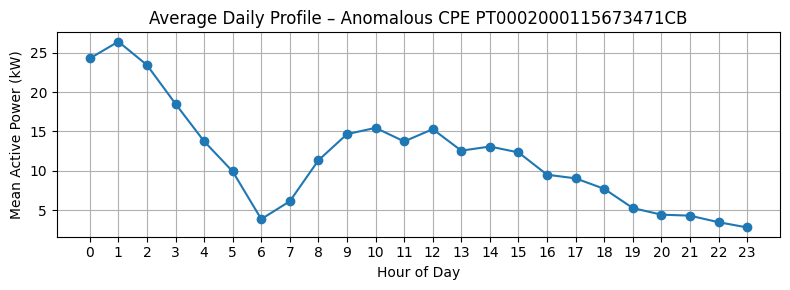

In [33]:
for cpe in top10_cpes:
    df_cpe = df[df["CPE"] == cpe].sort_values(time_col)
    curve_cpe_day = df_cpe.groupby("hour")[power_col].mean()

    plt.figure(figsize=(8, 3))
    plt.plot(curve_cpe_day.index, curve_cpe_day.values, marker="o")
    plt.title(f"Average Daily Profile – Anomalous CPE {cpe}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Mean Active Power (kW)")
    plt.grid(True)
    plt.xticks(range(24))
    plt.tight_layout()
    plt.show()

## 3. Data Preparation

In this section, we clean and transform the data to build:

- a **time-series dataset** per CPE (for ARIMA / LSTM),
- a **feature table per CPE** (for clustering and non-sequential models).


In [34]:
df_prep = df.copy()

### 3.1 Remove Duplicates and Inconsistent Rows

In [35]:
before = df_prep.shape[0]
df_prep = df_prep.drop_duplicates(subset=["CPE", time_col])
after = df_prep.shape[0]

print("Removed duplicates:", before - after)

Removed duplicates: 1230


### 3.3 Remove Rows Where All Power Metrics Are Missing

In [36]:
metric_cols = [power_col, react_ind_col, react_cap_col]
if consumption_col in df_prep.columns:
    metric_cols.append(consumption_col)

df_prep = df_prep.dropna(subset=metric_cols, how="all")
print("Shape after removing fully-missing metric rows:", df_prep.shape)

Shape after removing fully-missing metric rows: (5938952, 11)


### 3.4 Build CPE-Level Feature Table (for Clustering / Non-Sequential Models)

In [37]:
agg_funcs = {
    power_col: ["mean", "max", "min", "std"],
    react_ind_col: ["mean"],
    react_cap_col: ["mean"],
}

df_features_cpe = (
    df_prep.groupby("CPE")
           .agg(agg_funcs)
)

df_features_cpe.columns = ["_".join(col).strip() for col in df_features_cpe.columns.values]
df_features_cpe

,PotActiva_mean,PotActiva_max,PotActiva_min,PotActiva_std,PotReactIndut_mean,PotReactCapac_mean
CPE,,,,,,
PT0002000032936306KX,2.436308,30.756,0.0,2.779039,NaN,NaN
PT0002000032942455NH,0.090892,2.860,0.0,0.131165,NaN,NaN
PT0002000032959511HP,0.000000,0.000,0.0,0.000000,NaN,NaN
PT0002000032966446CC,0.099789,2.244,0.0,0.105208,NaN,NaN
PT0002000032968749YT,3.640015,31.496,0.0,4.001387,NaN,NaN
...,...,...,...,...,...,...
PT0002000125379984SH,4.752051,63.000,0.0,4.824346,0.034950,2.128734
PT0002000131605602FL,1.325036,4.684,0.0,1.587777,NaN,NaN
PT0002000133505542CK,0.113278,0.236,0.0,0.013814,NaN,NaN


In [43]:
def engineer_advanced_features(df, time_col, power_col):
    """
    Cria features avançadas por CPE com controlo de erros,
    evitando NaN, divisões inválidas e inconsistências.
    """

    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=[time_col])

    feature_rows = []

    for cpe, g in df.groupby("CPE"):

        g = g.sort_values(time_col).copy()
        g["hour"] = g[time_col].dt.hour
        g["weekday"] = g[time_col].dt.weekday
        g["date"] = g[time_col].dt.date
        
        power = g[power_col].astype(float)

        # ===============================
        # 1️⃣ Estatísticas gerais
        # ===============================
        mean_power = power.mean()
        max_power = power.max()
        min_power = power.min()
        std_power = power.std()
        amplitude_power = max_power - min_power if pd.notna(max_power) else np.nan

        # ===============================
        # 2️⃣ Consumo por períodos do dia
        # ===============================
        morning_mask = (g["hour"] >= 6) & (g["hour"] < 12)
        afternoon_mask = (g["hour"] >= 12) & (g["hour"] < 18)
        night_mask = (g["hour"] >= 18) | (g["hour"] < 6)

        morning = power[morning_mask].mean()
        afternoon = power[afternoon_mask].mean()
        night = power[night_mask].mean()

        total = power.sum()

        if total is not None and total > 0:
            pct_morning = power[morning_mask].sum() / total
            pct_afternoon = power[afternoon_mask].sum() / total
            pct_night = power[night_mask].sum() / total
        else:
            pct_morning = np.nan
            pct_afternoon = np.nan
            pct_night = np.nan

        # ===============================
        # 3️⃣ Pico diário
        # ===============================
        try:
            daily_peaks = g.groupby("date")[power_col].max()
            mean_daily_peak = daily_peaks.mean()
            avg_daily_peak_time = (
                g.loc[g.groupby("date")[power_col].idxmax()][time_col]
                .dt.hour.mean()
            )
        except Exception:
            mean_daily_peak = np.nan
            avg_daily_peak_time = np.nan

        # ===============================
        # 4️⃣ Tempo abaixo de 50% do pico diário
        # ===============================
        threshold = 0.5 * max_power if pd.notna(max_power) else np.nan
        if pd.notna(threshold):
            pct_time_below_50 = (power < threshold).mean()
        else:
            pct_time_below_50 = np.nan

        # ===============================
        # 5️⃣ Variabilidade semanal
        # ===============================
        try:
            g["week"] = g[time_col].dt.isocalendar().week
            weekly_means = g.groupby("week")[power_col].mean()
            weekly_variability = weekly_means.std()
        except Exception:
            weekly_variability = np.nan

        # ===============================
        # 6️⃣ Autocorrelação lag 1
        # ===============================
        if len(power.dropna()) > 1:
            autocorr_lag1 = power.autocorr(lag=1)
        else:
            autocorr_lag1 = np.nan

        # ===============================
        # 7️⃣ LAG features
        # ===============================
        lag1 = power.shift(1).mean()
        lag24 = power.shift(96).mean()        # 96 amostras = 1 dia (15 min)
        lag_week = power.shift(96 * 7).mean() # 1 semana

        # ===============================
        # Guardar
        # ===============================
        feature_rows.append({
            "CPE": cpe,
            "mean_power": mean_power,
            "max_power": max_power,
            "min_power": min_power,
            "std_power": std_power,
            "amplitude_power": amplitude_power,

            "mean_power_morning": morning,
            "mean_power_afternoon": afternoon,
            "mean_power_night": night,

            "pct_morning": pct_morning,
            "pct_afternoon": pct_afternoon,
            "pct_night": pct_night,

            "mean_daily_peak": mean_daily_peak,
            "avg_daily_peak_time": avg_daily_peak_time,
            "pct_time_below_50": pct_time_below_50,

            "weekly_variability": weekly_variability,
            "autocorr_lag1": autocorr_lag1,

            "lag1_mean": lag1,
            "lag24_mean": lag24,
            "lag_week_mean": lag_week
        })

    # index por CPE (necessário para .join)
    return pd.DataFrame(feature_rows).set_index("CPE")


In [3]:
df_features_new = engineer_advanced_features(df_prep, time_col=time_col, power_col=power_col)

# Remover colunas duplicadas automaticamente
df_features_cpe = df_features_cpe.drop(
    columns=df_features_new.columns.intersection(df_features_cpe.columns),
    errors="ignore"
)

# Join final sem conflitos
df_features_cpe = df_features_cpe.join(df_features_new, how="left")

df_features_cpe.head()

NameError: name 'engineer_advanced_features' is not defined

In [127]:
df_prep.to_csv(INTERIM_DIR / "maia_timeseries_clean.csv", index=False)
df_features_cpe.to_csv(INTERIM_DIR / "maia_features_per_cpe.csv")
print("Saved cleaned time-series and CPE-level features.")

Saved cleaned time-series and CPE-level features.


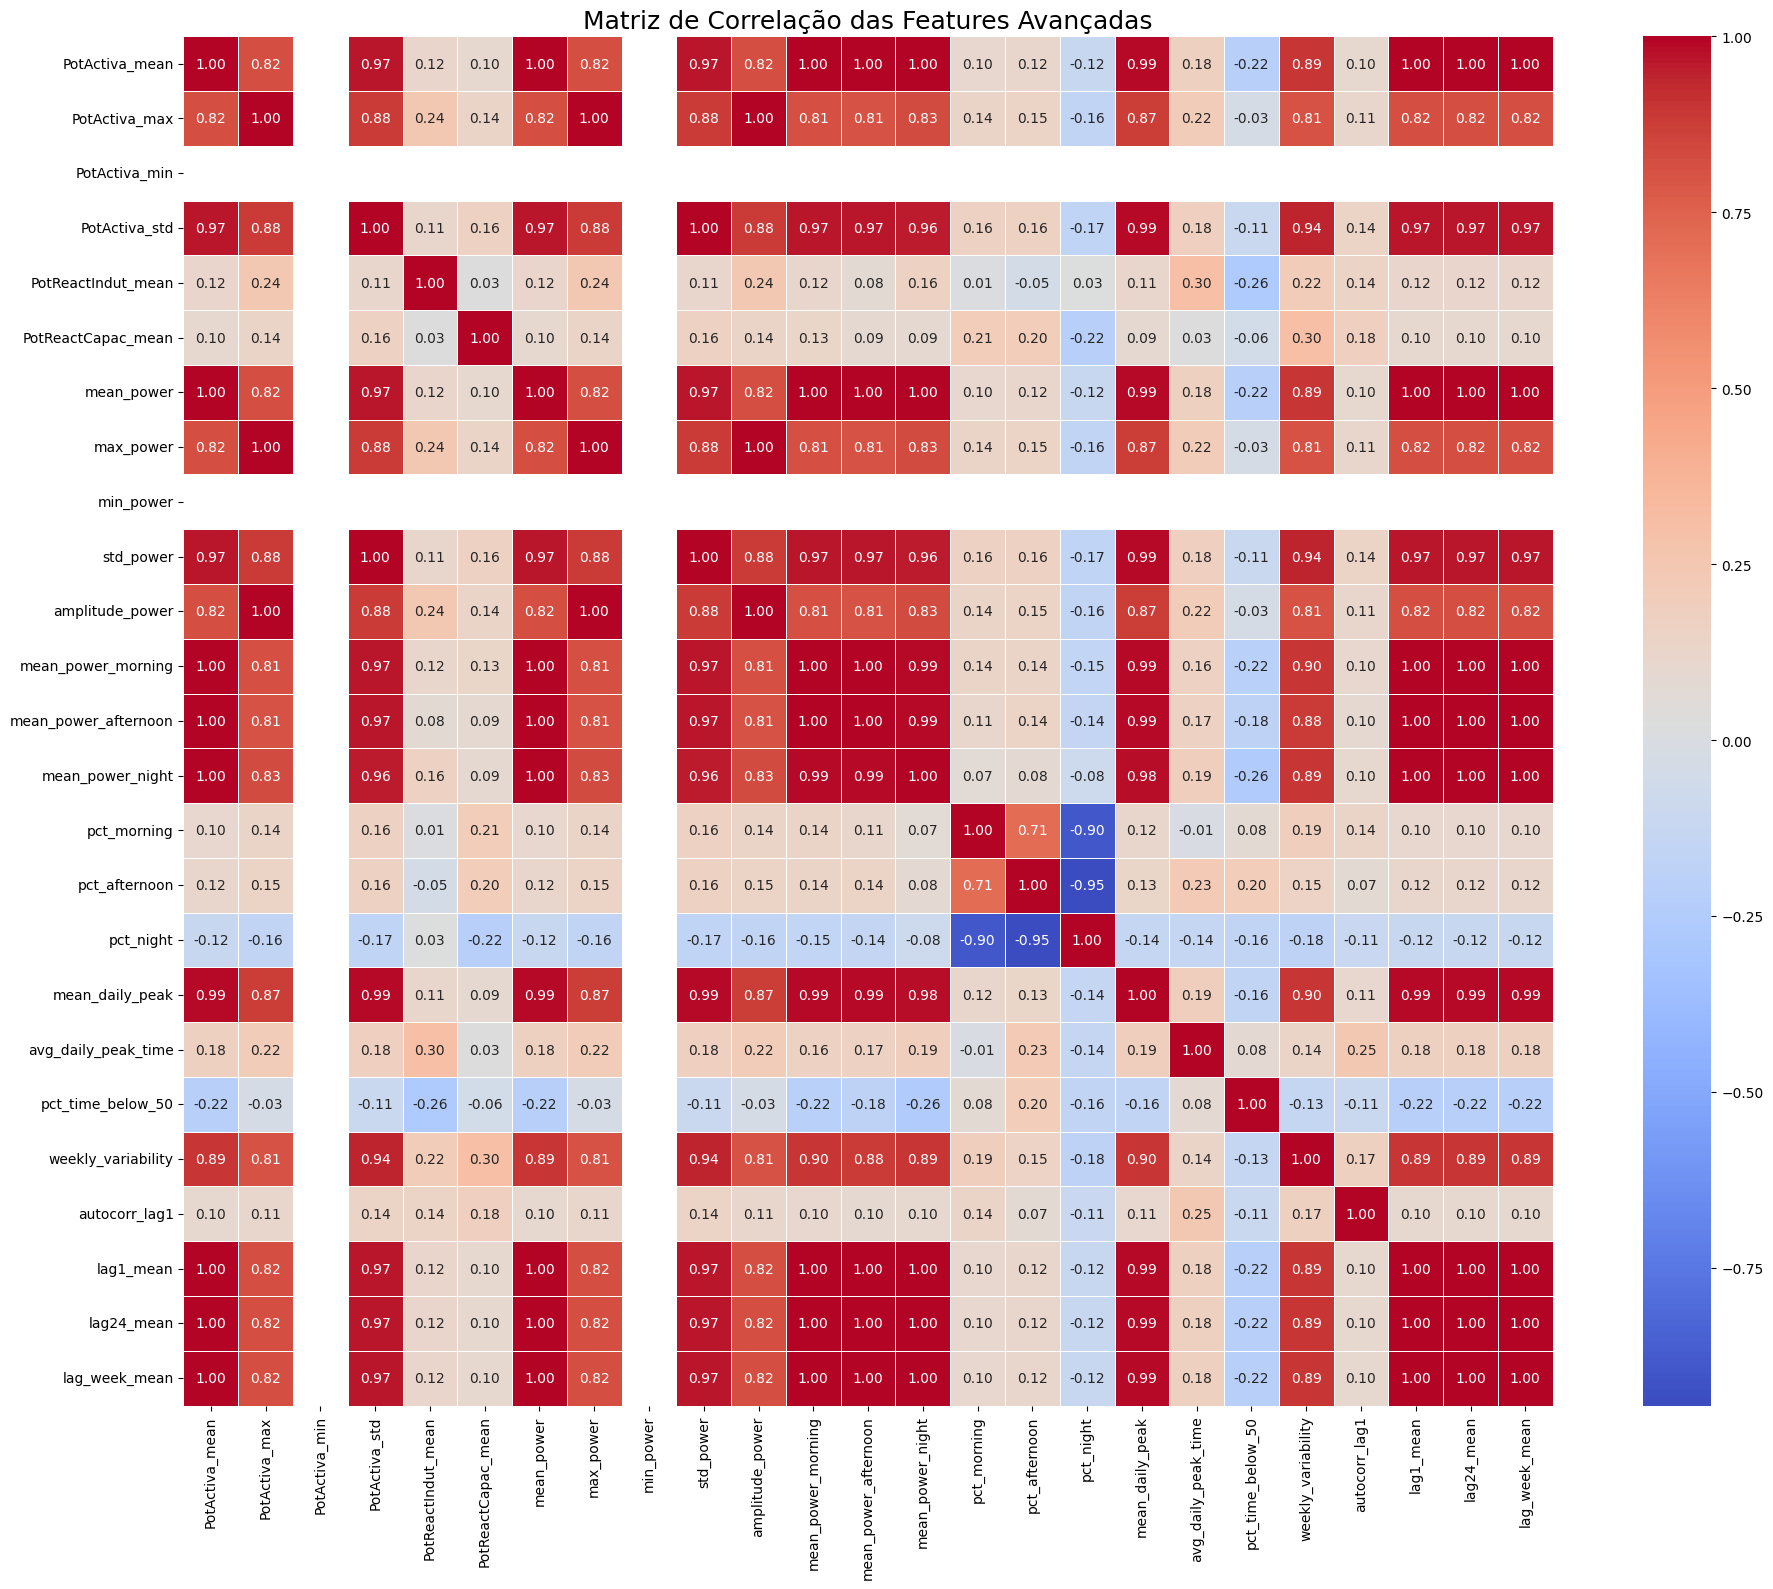

In [49]:
df_corr = df_features_cpe.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(20, 16))
sns.heatmap(
    df_corr,
    cmap="coolwarm",
    annot=True,        # Mostra os valores numéricos
    fmt=".2f",         # Formato dos números (2 casas decimais)
    square=True,
    linewidths=0.5,
    cbar=True
)

plt.title("Matriz de Correlação das Features Avançadas", fontsize=18)
plt.tight_layout()
plt.show()


In [52]:
corr = df_features_cpe.select_dtypes(include=[np.number]).corr().abs()

threshold = 0.95

high_corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))   # metade superior
        .stack()
        .reset_index()
)

high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] >= threshold]

high_corr_pairs


,Feature_1,Feature_2,Correlation
1,PotActiva_mean,PotActiva_std,0.966217
4,PotActiva_mean,mean_power,1.000000
6,PotActiva_mean,std_power,0.966217
8,PotActiva_mean,mean_power_morning,0.998275
9,PotActiva_mean,mean_power_afternoon,0.996946
10,PotActiva_mean,mean_power_night,0.995973
14,PotActiva_mean,mean_daily_peak,0.989862
19,PotActiva_mean,lag1_mean,1.000000
20,PotActiva_mean,lag24_mean,1.000000
21,PotActiva_mean,lag_week_mean,0.999999


In [51]:
corr = df_features_cpe.select_dtypes(include=[np.number]).corr()

pairs = []

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i, j] == 1:
            pairs.append((corr.columns[i], corr.columns[j]))

pairs


[('PotActiva_mean', 'mean_power'),
 ('PotActiva_max', 'max_power'),
 ('PotActiva_max', 'amplitude_power'),
 ('max_power', 'amplitude_power')]

## 4. Modeling (Placeholders)

This section will include:

1. **Unsupervised learning (clustering)**:  
   - K-Means  
   - DBSCAN  

2. **Supervised learning (time-series forecasting)**:  
   - ARIMA  
   - LSTM  

3. **Supervised learning (feature-based models)**:  
   - Random Forest  
   - XGBoost  
   - MLP  

and comparisons against the **baseline** (same time one week before).


### 4.1 Clustering (K-Means, DBSCAN) 

In [ ]:
from sklearn.cluster import KMeans, DBSCAN

features_for_clustering = df_features_cpe.select_dtypes(include=[np.number]).dropna(axis=1)
scaler_clust = StandardScaler()
X_clust = scaler_clust.fit_transform(features_for_clustering)


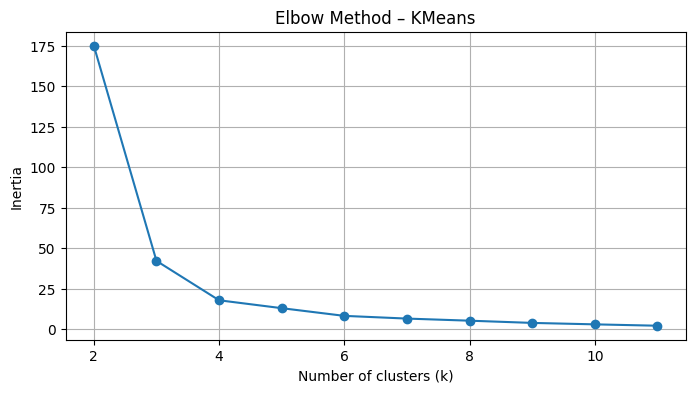

In [ ]:
# Elbow method to inspect optimal number of clusters
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 12)

for k in K_range:
    km_tmp = KMeans(n_clusters=k, random_state=42)
    km_tmp.fit(X_clust)
    inertias.append(km_tmp.inertia_)

plt.figure(figsize=(8,4))
plt.plot(list(K_range), inertias, marker="o")
plt.title("Elbow Method – KMeans")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

In [ ]:
# Silhouette score for different k values
from sklearn.metrics import silhouette_score

for k in range(2, 12):
    km_tmp = KMeans(n_clusters=k, random_state=42)
    labels_tmp = km_tmp.fit_predict(X_clust)
    sil = silhouette_score(X_clust, labels_tmp)
    print(f"K={k} – Silhouette Score: {sil:.4f}")

K=2 – Silhouette Score: 0.8948
K=3 – Silhouette Score: 0.8243
K=4 – Silhouette Score: 0.8275
K=5 – Silhouette Score: 0.7886
K=6 – Silhouette Score: 0.5601
K=7 – Silhouette Score: 0.5455
K=8 – Silhouette Score: 0.5667
K=9 – Silhouette Score: 0.5631
K=10 – Silhouette Score: 0.5449
K=11 – Silhouette Score: 0.5459


In [ ]:
from sklearn.cluster import KMeans, DBSCAN

features_for_clustering = df_features_cpe.select_dtypes(include=[np.number]).dropna(axis=1)
scaler_clust = StandardScaler()
X_clust = scaler_clust.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=4, random_state=42)
df_features_cpe["cluster_kmeans"] = kmeans.fit_predict(X_clust)
df_features_cpe["cluster_kmeans"].value_counts()

cluster_kmeans
0    75
2    14
3     1
1     1
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_clust, df_features_cpe["cluster_kmeans"])
print("Silhouette score (K-Means):", sil_score)

Silhouette score (K-Means): 0.8274845422501841


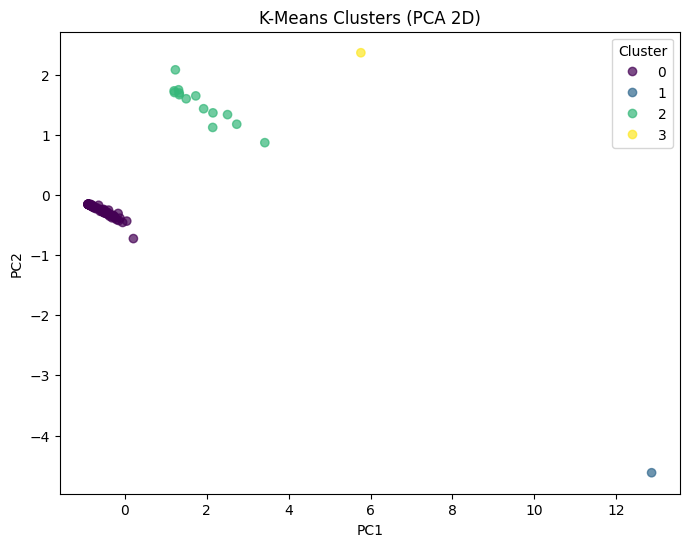

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clust)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df_features_cpe["cluster_kmeans"], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means Clusters (PCA 2D)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

#### 4.1.1 DBSCAN Clustering and Outlier Detection

In [ ]:
from sklearn.cluster import DBSCAN

# DBSCAN on the same scaled feature space
dbscan = DBSCAN(eps=1.3, min_samples=4)
df_features_cpe["cluster_dbscan"] = dbscan.fit_predict(X_clust)

print("DBSCAN cluster label counts:")
print(df_features_cpe["cluster_dbscan"].value_counts())

DBSCAN cluster label counts:
cluster_dbscan
 0    75
 1    14
-1     2
Name: count, dtype: int64


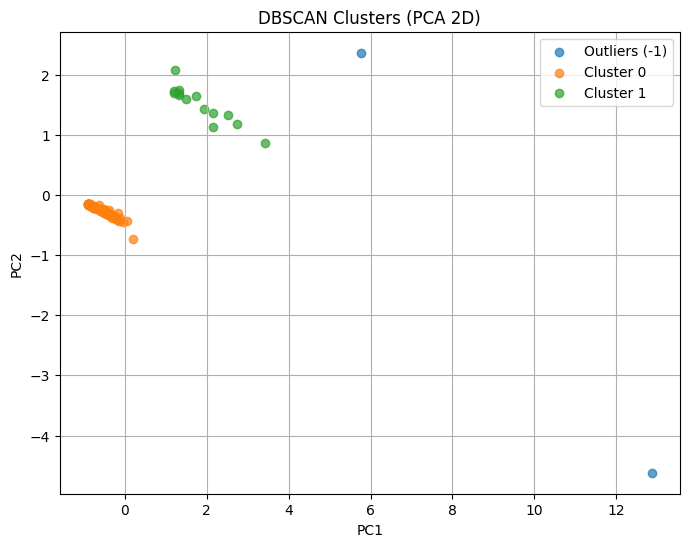

In [ ]:
# PCA visualization for DBSCAN clusters
unique_labels = sorted(df_features_cpe["cluster_dbscan"].unique())
plt.figure(figsize=(8,6))

for lab in unique_labels:
    mask = df_features_cpe["cluster_dbscan"] == lab
    label_name = f"Cluster {lab}" if lab != -1 else "Outliers (-1)"
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], alpha=0.7, label=label_name)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN Clusters (PCA 2D)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# List CPEs flagged as outliers by DBSCAN
outliers_dbscan = df_features_cpe[df_features_cpe["cluster_dbscan"] == -1]
print("Outlier CPEs detected by DBSCAN:")
outliers_dbscan.index.tolist()

Outlier CPEs detected by DBSCAN:


['PT0002000068859325FL', 'PT0002000078441876HB']

### 4.2 Time-Series Models (ARIMA, LSTM) – Skeleton

In [ ]:
def time_series_train_test_split(df_cpe, time_col, train_ratio=0.7):
    df_cpe = df_cpe.sort_values(time_col)
    n = len(df_cpe)
    split_idx = int(n * train_ratio)
    df_train = df_cpe.iloc[:split_idx]
    df_test = df_cpe.iloc[split_idx:]
    return df_train, df_test

#### 4.2.1 ARIMA Time-Series Model and Weekly-Lag Baseline (per CPE)

c:\Users\alexm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\alexm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\alexm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\alexm\AppData\Local\Programs\Python\Python310\lib

Example CPE for ARIMA: PT0002000033074862LZ
Baseline (weekly lag) – MAE: 1.9407256420709336 RMSE: 3.592264189297232
ARIMA model           – MAE: 5.508184392042354 RMSE: 7.519550030212737


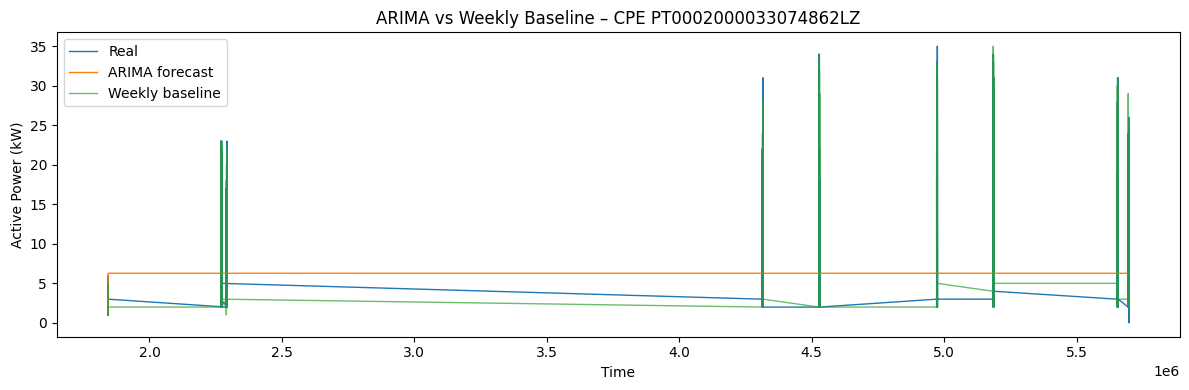

In [ ]:
# Example ARIMA model and baseline for a single CPE
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# choose an example CPE with enough data
example_cpe_ts = df_prep["CPE"].value_counts().index[0]
df_cpe_ts = df_prep[df_prep["CPE"] == example_cpe_ts].sort_values(time_col).copy()

# keep only the active power series
series = df_cpe_ts[power_col].astype(float)

# split into train/test using the helper
df_train_ts, df_test_ts = time_series_train_test_split(df_cpe_ts, time_col=time_col, train_ratio=0.7)

y_train_ts = df_train_ts[power_col].astype(float)
y_test_ts = df_test_ts[power_col].astype(float)

# Baseline: same time one week before (96 * 7 intervals for 15-min data)
lag_week = 96 * 7
baseline_series = series.shift(lag_week)

baseline_test = baseline_series.loc[y_test_ts.index]
baseline_test = baseline_test.reindex(y_test_ts.index)

# Simple ARIMA model on training set
model_arima = ARIMA(y_train_ts, order=(3,0,2))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(y_test_ts))

# Align forecast index with test index
forecast_arima.index = y_test_ts.index

mae_base_ts = mean_absolute_error(y_test_ts.dropna(), baseline_test.dropna())
rmse_base_ts = mean_squared_error(y_test_ts.dropna(), baseline_test.dropna())**0.5

mae_arima = mean_absolute_error(y_test_ts, forecast_arima)
rmse_arima = mean_squared_error(y_test_ts, forecast_arima)**0.5

print(f"Example CPE for ARIMA: {example_cpe_ts}")
print("Baseline (weekly lag) – MAE:", mae_base_ts, "RMSE:", rmse_base_ts)
print("ARIMA model           – MAE:", mae_arima,   "RMSE:", rmse_arima)

plt.figure(figsize=(12,4))
plt.plot(y_test_ts.index, y_test_ts.values, label="Real", linewidth=1)
plt.plot(y_test_ts.index, forecast_arima.values, label="ARIMA forecast", linewidth=1)
plt.plot(y_test_ts.index, baseline_test.values, label="Weekly baseline", linewidth=1, alpha=0.7)
plt.title(f"ARIMA vs Weekly Baseline – CPE {example_cpe_ts}")
plt.xlabel("Time")
plt.ylabel("Active Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Algorithms

In [ ]:
def compute_next_week_target(df_in, time_col, power_col):
    targets = {}

    for cpe, g in df_in.groupby("CPE"):
        g = g.sort_values(time_col).copy()
        g["week"] = g[time_col].dt.isocalendar().week
        g["year"] = g[time_col].dt.year
        
        weekly = g.groupby(["year", "week"])[power_col].mean()

        y_values = weekly.shift(-1)  # previsão da semana seguinte
        df_tmp = pd.DataFrame({
            "weekly_mean_power": weekly.values,
            "target_next_week": y_values.values
        }, index=weekly.index)

        df_tmp = df_tmp.dropna()

        if len(df_tmp) > 0:
            targets[cpe] = df_tmp.iloc[-1]["target_next_week"]

    return pd.Series(targets, name="target_next_week")


In [ ]:
targets = compute_next_week_target(df_prep, time_col, power_col)


In [ ]:
df_features = df_features_cpe.copy()

df_features = df_features.join(targets, how="inner")
df_features.head()


,PotActiva_mean,PotActiva_max,PotActiva_min,PotActiva_std,PotReactIndut_mean,PotReactCapac_mean,cluster_kmeans,target_next_week
CPE,,,,,,,,
PT0002000032936306KX,2.436308,30.756,0.0,2.779039,NaN,NaN,0,2.166962
PT0002000032942455NH,0.090892,2.860,0.0,0.131165,NaN,NaN,0,0.164817
PT0002000032959511HP,0.000000,0.000,0.0,0.000000,NaN,NaN,0,0.000000
PT0002000032966446CC,0.099789,2.244,0.0,0.105208,NaN,NaN,0,0.141619
PT0002000032968749YT,3.640015,31.496,0.0,4.001387,NaN,NaN,0,4.473398


In [ ]:
X = df_features.drop(columns=["target_next_week"])
y = df_features["target_next_week"]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    min_samples_split=3
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = mean_squared_error(y_test, pred_rf)**0.5


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    max_depth=5,
    random_state=42
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, pred_xgb)
rmse_xgb = mean_squared_error(y_test, pred_xgb)**0.5


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor

mlp_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64,32),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    ))
])

mlp_pipe.fit(X_train, y_train)
pred_mlp = mlp_pipe.predict(X_test)

mae_mlp = mean_absolute_error(y_test, pred_mlp)
rmse_mlp = mean_squared_error(y_test, pred_mlp)**0.5


c:\Users\alexm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
baseline_mean = y_train.mean()
baseline_pred = np.full_like(y_test, baseline_mean)

mae_base = mean_absolute_error(y_test, baseline_pred)
rmse_base = mean_squared_error(y_test, baseline_pred)**0.5


In [ ]:
results = pd.DataFrame({
    "MAE": [mae_base, mae_rf, mae_xgb, mae_mlp],
    "RMSE": [rmse_base, rmse_rf, rmse_xgb, rmse_mlp]
}, index=["Baseline", "Random Forest", "XGBoost", "MLP"])

results


,MAE,RMSE
Baseline,7.187171,8.112740
Random Forest,2.555774,6.634177
XGBoost,0.861366,1.328949
MLP,1.690878,3.756377


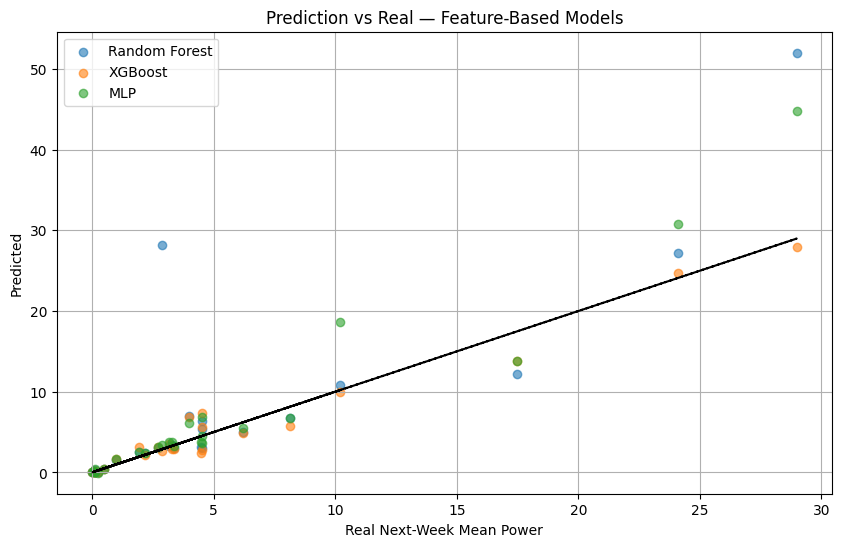

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, pred_rf, alpha=0.6, label="Random Forest")
plt.scatter(y_test, pred_xgb, alpha=0.6, label="XGBoost")
plt.scatter(y_test, pred_mlp, alpha=0.6, label="MLP")

plt.plot(y_test, y_test, 'k--')  # linha perfeição
plt.xlabel("Real Next-Week Mean Power")
plt.ylabel("Predicted")
plt.legend()
plt.title("Prediction vs Real — Feature-Based Models")
plt.grid(True)
plt.show()
